# FOIL Project 4: Overcoming catastrophic forgetting in neural networks.

[This paper](https://arxiv.org/pdf/1612.00796.pdf), by James Kirkpatrick et al., studies the setting of continual learning, where an agent learns multiple tasks sequentially, i.e., accumulating knowledge for a new task/experience without having access to data from past tasks. In this setting, the phenomenon of catastrophic forgetting arises; the performance of the agent on past experiences significantly diminishes upon learning new tasks. The paper proposes the use of a regularization term to combat this problem. We suggest steering from the reinforcement learning experience and, instead, focus on supervised learning. Reproduce the results of Figure 2 (subfigures A + B) on the following datasets: PermutedMNIST (as in the paper) as well as RotatedMNIST (ten tasks of rotating MNIST, where task i is produced by a fixed rotation of 10(i − 1) degrees). Compare the results of the proposed regularization with naive L2 regularization and no regularization.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

### Load the data:

Create three tasks of permuted MNIST

In [ ]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
Task = namedtuple("Task", ["name", "train", "test"])

def create_permuted_mnist(rng, store_perm=False):
    """
    Create a permuted MNIST dataset for a given task ID using a shared random number generator.
    """
    perm = torch.tensor(rng.permutation(28 * 28), dtype=torch.long)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)[perm].view(1, 28, 28))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    if store_perm: # in case we want to reproduce the same permutation and if we want to see that they are really different
        return train_dataset, test_dataset, perm
        
    return train_dataset, test_dataset

# Fix a single seed
seed = 42
rng = np.random.RandomState(seed)

# Create permuted tasks
Original_MNIST = Task(name="Original MNIST", train=mnist_train, test=mnist_test)
perm_tasks = [
    Task(name="A: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
    Task(name="B: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
    Task(name="C: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1])
]

for task in [Original_MNIST] + perm_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()


Create rotated MNIST datasets:

In [ ]:
def create_rotated_mnist(task_id, base_angle=0):
    rotation_angle = base_angle + 10 * (task_id - 1)  # Fixed rotation for task
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=rotation_angle))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Generate ten tasks of Rotated MNIST
rot_tasks = [
    Task(
        name=f"Task {i}: Rotated MNIST {10 * (i - 1)}°",
        train=create_rotated_mnist(i)[0],
        test=create_rotated_mnist(i)[1]
    )
    for i in range(1, 11)
]

# Visualize samples from each task
for task in rot_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Rotated MNIST: Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()

## Add the model

The paper proposes a fully connected network (FCN)

They don't mention the size of the validation set, should we just take 20% ?

In [62]:
class Fcn(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, dropout=False):
        super(Fcn, self).__init__()
        layers = [torch.nn.Flatten()] # Flatten the input tensor for fcn
        
        # MNIST image flattened vector to first hidden layer
        layers.append(nn.Linear(28*28, hidden_size))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=0.2))
        
        # hidden layers 
        # NOTE: not entirely sure if this is what they ment by hidden layers, my interpretation is
        # that they want the same number of fc layers here as they said in the paper + separate input and output layers...
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=0.5))
        
        # NOTE: maybe this layer should be removed and the last one of the above should already map to 10 classes? (I don't think so)
        # output layer (map to 10 classes for MNIST)
        layers.append(nn.Linear(hidden_size, 10))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
    def compute_fisher_information(self, dataloader, criterion):
        """Computes the diagonal Fisher Information Matrix (FIM)."""
        fisher_matrix = {}
        self.eval()
        
        for name, param in self.named_parameters():
            fisher_matrix[name] = torch.zeros_like(param)
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(next(self.parameters()).device), targets.to(next(self.parameters()).device)
            self.zero_grad()
            outputs = self.forward(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            for name, param in self.named_parameters():
                fisher_matrix[name] += param.grad ** 2 / len(dataloader)
        
        for name in fisher_matrix:
            self.fisher_info[name] = fisher_matrix[name].detach()
            self.saved_params[name] = self.state_dict()[name].detach().clone()

    def ewc_loss(self, lambda_ewc):
        """Computes the EWC regularization loss."""
        ewc_loss = 0.0
        for name, param in self.named_parameters():
            if name in self.fisher_info:
                ewc_loss += torch.sum(self.fisher_info[name] * (param - self.saved_params[name]) ** 2)
        return lambda_ewc * ewc_loss            

In [254]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
class Fcn(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, dropout=False):
        super(Fcn, self).__init__()
        layers = [torch.nn.Flatten()]  # Flatten the input tensor for FCN
        
        # Input to first hidden layer
        layers.append(nn.Linear(28 * 28, hidden_size))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=0.2))
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=0.5))
        
        # Output layer (mapping to 10 classes for MNIST)
        layers.append(nn.Linear(hidden_size, 10))
        
        self.model = nn.Sequential(*layers)
        
        # Initialize for EWC
        self.fisher_info = {}
        self.old_params = {}
        self.ewc_lambda = 0.0

    def forward(self, x):
        return self.model(x)

    def _compute_fisher(self, dataset):
        """Compute Fisher information matrix for EWC."""
        fisher = {
            n: torch.zeros_like(p)
            for n, p in self.named_parameters()
            if p.requires_grad
        }
        
        self.eval()  # Set the model to evaluation mode
        
        # Create DataLoader
        loader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        # Compute Fisher information
        for batch_embeddings, batch_labels in loader:
            self.zero_grad()
            
            # Get model outputs
            outputs = self(batch_embeddings)
            
            # Compute probabilities and log-probabilities
            probs = F.softmax(outputs, dim=1)
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Sample labels from the output distribution
            sampled_labels = torch.multinomial(probs, 1).squeeze()
            
            # Compute loss with sampled labels
            loss = F.nll_loss(log_probs, sampled_labels)
            
            # Compute gradients
            loss.backward()
            
            # Accumulate Fisher information
            for n, p in self.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data ** 2 / len(loader)
        
        return fisher

    def consolidate(self, dataset: torch.utils.data.Dataset, ewc_lambda: float):
        """Update Fisher information and old parameters after training a task."""
        new_fisher_info = self._compute_fisher(dataset)
        for n, p in new_fisher_info.items():
            if n in self.fisher_info:
                #print(f"Parameter: {n}, Fisher: {p.mean().item()}")
                self.fisher_info[n] += p  # Accumulate Fisher information
            else:
                self.fisher_info[n] = p.clone()
        self.old_params = {
            n: p.data.clone()
            for n, p in self.named_parameters()
            if p.requires_grad
        }
        self.ewc_lambda = ewc_lambda

            

    def ewc_loss(self, batch_size = None):
        """Compute EWC loss."""
        loss = 0
        for n, p in self.named_parameters():
            if p.requires_grad and n in self.fisher_info:
                # Compute squared distance weighted by Fisher information
                _loss = (self.fisher_info[n] * (p - self.old_params[n]) ** 2).sum()
                loss += _loss
        
        # Normalize by batch size if provided
        if batch_size is not None:
            loss = loss / batch_size
        ewc_loss = self.ewc_lambda * loss
        #print(f"EWC Loss: {ewc_loss.item()}")

        return ewc_loss

## Train Functions

In [35]:
# Function ot train the model
# Add early stopping
# also add loss as optimizer I think to be able to do EWC...
def train_sequential_tasks(model, train_tasks, optimizer, num_epochs=10, early_stopping=False, l2_reg = 0.0):
    criterion = nn.CrossEntropyLoss()

    n_tasks = len(train_tasks)

    train_loaders = [DataLoader(task.train, batch_size=64, shuffle=True) for task in train_tasks]

    train_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))

    # Sequentially train on tasks
    for i, train_loader in enumerate(train_loaders):
        print(f"Training on Task {i + 1}/{len(train_tasks)}")

        for epoch in range(num_epochs):
            model.train()
            correct = 0
            total = 0

            # Training on current task
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss = criterion(outputs, labels)

                if l2_reg > 0 and i > 0:
                    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                    loss += l2_reg * l2_norm

                loss.backward()
                optimizer.step()

            # Store current task accuracy for this epoch
            current_task_accuracy = correct / total
            train_accuracies[i, i * num_epochs + epoch] = current_task_accuracy

            print(f"Epoch {epoch + 1}/{num_epochs}\t Accuracy: {current_task_accuracy:.4f} -> Evaluating on previous tasks...", end=" ")

            # Evaluate performance on all previous tasks
            for j, loader in enumerate(train_loaders[:i]):
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)
                task_accuracy = correct / total
                train_accuracies[j, i * num_epochs + epoch] = task_accuracy

            print("Finished!")

    return train_accuracies

In [ ]:
def train_sequential_tasks_ismail(model, train_tasks, optimizer, num_epochs=10, early_stopping=True, ewc=False, lambda_ewc = 15):
    setting = "EWC" if ewc else "Normal SGD"
    print("Setting of training: " + setting)

    criterion = nn.CrossEntropyLoss()

    n_tasks = len(train_tasks)
    train_loaders = []
    val_loaders = []

    # Split train datasets into train and validation sets
    for task in train_tasks: 
        train_size = int(0.8 * len(task.train))  # 80% train, 20% validation
        val_size = len(task.train) - train_size
        train_subset, val_subset = random_split(task.train, [train_size, val_size])
        train_loaders.append(DataLoader(train_subset, batch_size=64, shuffle=True))
        val_loaders.append(DataLoader(val_subset, batch_size=64, shuffle=False))

    train_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))
    val_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))

    best_model_state = None
    best_avg_val_error = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5

    # Sequentially train on tasks
    for i, train_loader in enumerate(train_loaders):
        print(f"Training on Task {i + 1}/{len(train_tasks)}")
        
        if (i > 0) and ewc:
            model.compute_fisher_information(train_loaders[i-1], criterion)

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            # Training on current task
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                loss = criterion(outputs, labels)
                if (i > 0) and ewc:
                    loss += model.ewc_loss(lambda_ewc)
                    
                loss.backward()
                optimizer.step()

            # Store current task accuracy for this epoch
            current_task_accuracy = correct_train / total_train
            train_accuracies[i, i * num_epochs + epoch] = current_task_accuracy

            # Validation on current task
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loaders[i]:
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
            val_accuracy = correct_val / total_val
            val_accuracies[i, i * num_epochs + epoch] = val_accuracy

            print(f"Epoch {epoch + 1}/{num_epochs}\t Train Accuracy: {current_task_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f} -> Evaluating on previous tasks...", end=" ")

            # Evaluate performance on all previous tasks (training)
            for j, loader in enumerate(train_loaders[:i]):
                correct_train_prev = 0
                total_train_prev = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct_train_prev += (predicted == labels).sum().item()
                        total_train_prev += labels.size(0)
                train_accuracies[j, i * num_epochs + epoch] = correct_train_prev / total_train_prev
            
            # Evaluate performance on all previous tasks (validation)
            for j, loader in enumerate(val_loaders[:i]):
                correct_val_prev = 0
                total_val_prev = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct_val_prev += (predicted == labels).sum().item()
                        total_val_prev += labels.size(0)
                val_accuracies[j, i * num_epochs + epoch] = correct_val_prev / total_val_prev            
            
            # NOTE: tell me what you think of the all tasks calculation ? Not sure about it 
            all_tasks_val_accuracy = np.mean(val_accuracies[:, i * num_epochs + epoch])
            print(f"Val Accuracy: {all_tasks_val_accuracy:.4f}, early_stopping_counter: {early_stopping_counter},  Finished!")

            # Early stopping condition based on validation error (all tasks)
            # NOTE: my interpretation of "Early stopping was implemented by computing the test error on the
            # validation set for all pixel permutations" is that we should use val_accuracies of all tasks
            current_val_error = 1 - all_tasks_val_accuracy
            if current_val_error < best_avg_val_error:
                best_avg_val_error = current_val_error
                best_model_state = model.state_dict().copy()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered, restoring best model state.")
                model.load_state_dict(best_model_state)
                break

    return train_accuracies, val_accuracies


In [259]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
def evaluate_previous_tasks(model, train_loaders, val_loaders, train_accuracies, val_accuracies, 
                            current_task, epoch, num_epochs, criterion, train_losses=None, val_losses=None):
    """
    Evaluate the model on all previous tasks and update accuracies and losses.
    """
    if current_task > 0:
        print("-> Evaluating on previous tasks...", end=" ")
        # Evaluate all previous tasks (training)
        for task_idx, train_loader in enumerate(train_loaders):
            train_acc, train_loss = validate_model(model, train_loader, criterion)
            train_accuracies[task_idx, current_task * num_epochs + epoch] = train_acc
            if train_losses is not None:
                train_losses[task_idx, current_task * num_epochs + epoch] = train_loss

        # Evaluate all previous tasks (validation)
        for task_idx, val_loader in enumerate(val_loaders):
            val_acc, val_loss = validate_model(model, val_loader, criterion)
            #print(f"Val Accuracy: {val_acc:.4f}" , end=" ")
            val_accuracies[task_idx, current_task * num_epochs + epoch] = val_acc
            if val_losses is not None:
                val_losses[task_idx, current_task * num_epochs + epoch] = val_loss


In [260]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
def check_early_stopping(model, val_accuracies, task_idx, epoch, num_epochs, best_model_state, best_avg_val_error, counter):
    # NOTE: tell me what you think of the all tasks calculation ? Not sure about it 
    # Early stopping condition based on validation error (all tasks)
    # NOTE: my interpretation of "Early stopping was implemented by computing the test error on the
    # validation set for all pixel permutations" is that we should use val_accuracies of all tasks
    all_tasks_val_accuracy = np.mean(val_accuracies[:task_idx+1, task_idx * num_epochs + epoch])

    current_val_error = 1 - all_tasks_val_accuracy
    if current_val_error < best_avg_val_error:
        best_avg_val_error = current_val_error
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        
    print(f"Mean Val Accuracy: {all_tasks_val_accuracy:.4f},  Finished!")

    return best_model_state, counter, best_avg_val_error


In [263]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
def train_sequential_tasks_ismail(model, train_tasks, training_config):
    """
    Train a model sequentially on multiple tasks with support for different regularization modes.

    Parameters:
    - model: PyTorch model.
    - train_tasks: List of datasets for each task.
    - training_config: dictionnary containing {optimizer, num_epochs, criterion, early_stopping, regularization(mode, hyperparameter)}.    
    """
    
    optimizer = training_config["optimizer"]
    num_epochs = training_config["num_epochs"]
    criterion = training_config.get("criterion", nn.CrossEntropyLoss())
    early_stopping = training_config.get("early_stopping", False)
    early_stopping_patience = training_config.get("early_stopping_patience", 5)
    regularization = training_config.get("regularization", None)

    print_setup(regularization)

    train_loaders, val_loaders = prepare_data_loaders(train_tasks)
    n_tasks = len(train_tasks)

    metrics = {"train_accuracies": np.zeros((n_tasks, n_tasks * num_epochs)),
                "val_accuracies": np.zeros((n_tasks, n_tasks * num_epochs)),
                "train_losses": np.zeros((n_tasks, n_tasks * num_epochs)),
                "val_losses": np.zeros((n_tasks, n_tasks * num_epochs))}
    

    best_model_state, best_avg_val_error = None, float('inf')
    early_stopping_counter, early_stopping_patience = 0, 5

    # Sequentially train on tasks
    for task_idx, train_loader in enumerate(train_loaders):
        print(f"Training on Task {task_idx + 1}/{len(train_tasks)}")
        start_regularization = task_idx > 0


        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}\t", end=" ")

            # Training for one epoch amd storing the train accuracy
            current_task_train_acc, current_task_train_loss  = train_one_epoch(model, train_loader, optimizer, criterion, 
                                                                  regularization, start_regularization)
            print(f"Train Accuracy: {current_task_train_acc:.4f}, ", end=" ")

            metrics["train_accuracies"][task_idx, task_idx * num_epochs + epoch] = current_task_train_acc
            metrics["train_losses"][task_idx, task_idx * num_epochs + epoch] = current_task_train_loss
            # Validate on current task
            current_task_val_acc, current_task_val_loss = validate_model(model, val_loaders[task_idx], criterion) 
            print(f"Val Accuracy: {current_task_val_acc:.4f}" , end=" \t")
            metrics["val_accuracies"][task_idx, task_idx * num_epochs + epoch] = current_task_val_acc
            metrics["val_losses"][task_idx, task_idx * num_epochs + epoch] = current_task_val_loss
            
            # Evaluate on previous tasks
            evaluate_previous_tasks(model=model,train_loaders=train_loaders[:task_idx],val_loaders=val_loaders[:task_idx],
                                    train_accuracies=metrics["train_accuracies"],val_accuracies=metrics["val_accuracies"],current_task=task_idx,
                                    epoch=epoch,num_epochs=num_epochs,criterion=criterion,train_losses=metrics["train_losses"],
                                    val_losses=metrics["val_losses"])
            
            
            best_model_state, early_stopping_counter, best_avg_val_error = check_early_stopping(
                model, metrics["val_accuracies"], task_idx, epoch, num_epochs, 
                best_model_state, best_avg_val_error, early_stopping_counter
            )

            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered, restoring best model state.")
                model.load_state_dict(best_model_state)
                break

        # Consolidate Fisher information and parameters after training this task
        if regularization and regularization["mode"] == "ewc":
            model.consolidate(dataset=train_tasks[task_idx].train, ewc_lambda=regularization["hyperparameter"])
            
    return metrics


## Training

### Normal SGD

In [ ]:
from torchsummary import summary

model = Fcn(num_hidden_layers=2, hidden_size=400)

summary(model, input_size=(1,28,28))

In [ ]:
# Try the training with normal SGD and see what happens, takes like 10-12 mins for me
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 10

train_accuracies_sgd, val_accuracies_sgd = train_sequential_tasks_ismail(model, perm_tasks, optimizer, num_epochs=num_epochs)

The increasing all tasks val accuracy is weird no ? 

In [213]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
# Try the training with normal SGD and see what happens, takes like 10-12 mins for me
model = Fcn(num_hidden_layers=2, hidden_size=400)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 15
criterion = nn.CrossEntropyLoss()
early_stopping = False
regularization = None

training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["sgd"] = train_sequential_tasks_ismail(model=model, train_tasks=perm_tasks, training_config=training_config) 

***********permutation dataset***********
Training with Normal SGD
Training on Task 1/3
Epoch 1/15	 Train Accuracy: 0.1849,  Val Accuracy: 0.3120 Mean Val Accuracy: 0.3120,  Finished!
Epoch 2/15	 Train Accuracy: 0.4686,  Val Accuracy: 0.5649 Mean Val Accuracy: 0.5649,  Finished!
Epoch 3/15	 Train Accuracy: 0.5974,  Val Accuracy: 0.6254 Mean Val Accuracy: 0.6254,  Finished!
Epoch 4/15	 Train Accuracy: 0.6330,  Val Accuracy: 0.6496 Mean Val Accuracy: 0.6496,  Finished!
Epoch 5/15	 Train Accuracy: 0.6597,  Val Accuracy: 0.6733 Mean Val Accuracy: 0.6733,  Finished!
Epoch 6/15	 Train Accuracy: 0.6867,  Val Accuracy: 0.6971 Mean Val Accuracy: 0.6971,  Finished!
Epoch 7/15	 Train Accuracy: 0.7102,  Val Accuracy: 0.7148 Mean Val Accuracy: 0.7148,  Finished!
Epoch 8/15	 Train Accuracy: 0.7323,  Val Accuracy: 0.7430 Mean Val Accuracy: 0.7430,  Finished!
Epoch 9/15	 Train Accuracy: 0.7599,  Val Accuracy: 0.7742 Mean Val Accuracy: 0.7742,  Finished!
Epoch 10/15	 Train Accuracy: 0.7874,  Val Accura

In [ ]:
#print("***********rotated dataset***********")
#model = Fcn(num_hidden_layers=2, hidden_size=400) # Reset model
#metrics_rot["sgd"] = train_sequential_tasks_ismail(model=model, train_tasks=rot_tasks, training_config=training_config)

### With EWC

In [ ]:
# Train with EWC
model = Fcn(num_hidden_layers=2, hidden_size=400)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 20
lambda_ewc = 15  # Regularization strength

train_accuracies_ewc, val_accuracies_ewc = train_sequential_tasks_ismail(model, perm_tasks, optimizer, num_epochs=num_epochs, early_stopping=True, ewc=True, lambda_ewc = lambda_ewc)

In [266]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
# Train with EWC
model = Fcn(num_hidden_layers=2, hidden_size=400)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 15
criterion = nn.CrossEntropyLoss()
early_stopping = False
regularization = {"mode": "ewc", "hyperparameter": 400} # lambda_ewc = [20, 400, 1000]

training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["ewc"] = train_sequential_tasks_ismail(model, perm_tasks, training_config=training_config)

***********permutation dataset***********
Training with EWC regularization (lambda_ewc = 400)
Training on Task 1/3
Epoch 1/15	 Train Accuracy: 0.1996,  Val Accuracy: 0.2662 	Mean Val Accuracy: 0.2662,  Finished!
Epoch 2/15	 Train Accuracy: 0.3724,  Val Accuracy: 0.4521 	Mean Val Accuracy: 0.4521,  Finished!
Epoch 3/15	 Train Accuracy: 0.4963,  Val Accuracy: 0.5483 	Mean Val Accuracy: 0.5483,  Finished!
Epoch 4/15	 Train Accuracy: 0.5877,  Val Accuracy: 0.6207 	Mean Val Accuracy: 0.6207,  Finished!
Epoch 5/15	 Train Accuracy: 0.6509,  Val Accuracy: 0.6702 	Mean Val Accuracy: 0.6702,  Finished!
Epoch 6/15	 Train Accuracy: 0.6909,  Val Accuracy: 0.7096 	Mean Val Accuracy: 0.7096,  Finished!
Epoch 7/15	 Train Accuracy: 0.7184,  Val Accuracy: 0.7313 	Mean Val Accuracy: 0.7313,  Finished!
Epoch 8/15	 Train Accuracy: 0.7473,  Val Accuracy: 0.7616 	Mean Val Accuracy: 0.7616,  Finished!
Epoch 9/15	 Train Accuracy: 0.7768,  Val Accuracy: 0.7878 	Mean Val Accuracy: 0.7878,  Finished!
Epoch 10/15	

In [ ]:
#print("***********rotation dataset***********")
#model = Fcn(num_hidden_layers=2, hidden_size=400) # Reset model
#metrics_rot["ewc"] = train_sequential_tasks_ismail(model, rot_tasks, training_config=training_config)

No clue how they manage to get that high accuracy for the first task that quickly in the paper. Maybe they train with original mnist first to get closer?? Also the results are not like suuuper close but ok-ish I think...

### Try with L2 norm:

<span style="color:red"><b><<<<<<< local</b></span>

In [ ]:
# Try the training with L2 norm and see what happens

model = Fcn(num_hidden_layers=2, hidden_size=400)
# they don't specify the weight decay in the paper, so I just chose 1e-3, maybe we should increase...
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

num_epochs = 10

train_accuracies_l2 = train_sequential_tasks(model, perm_tasks, optimizer, num_epochs=num_epochs, l2_reg = 1e-2)

<span style="color:red"><b>=======</b></span>

In [277]:
def train_sequential_tasks(model, train_tasks, optimizer, num_epochs=10, early_stopping=False, l2_reg = 0.0):
    criterion = nn.CrossEntropyLoss()

    n_tasks = len(train_tasks)

    train_loaders = [DataLoader(task.train, batch_size=64, shuffle=True) for task in train_tasks]

    train_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))

    # Sequentially train on tasks
    for i, train_loader in enumerate(train_loaders):
        print(f"Training on Task {i + 1}/{len(train_tasks)}")

        for epoch in range(num_epochs):
            model.train()
            correct = 0
            total = 0

            # Training on current task
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss = criterion(outputs, labels)

                if l2_reg > 0 and i > 0:
                    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                    loss += l2_reg * l2_norm

                loss.backward()
                optimizer.step()

            # Store current task accuracy for this epoch
            current_task_accuracy = correct / total
            train_accuracies[i, i * num_epochs + epoch] = current_task_accuracy

            print(f"Epoch {epoch + 1}/{num_epochs}\t Accuracy: {current_task_accuracy:.4f} -> Evaluating on previous tasks...", end=" ")

            # Evaluate performance on all previous tasks
            for j, loader in enumerate(train_loaders[:i]):
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)
                task_accuracy = correct / total
                train_accuracies[j, i * num_epochs + epoch] = task_accuracy

            print("Finished!")

    return train_accuracies

<span style="color:red"><b>>>>>>>> remote</b></span>

In [278]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
model = Fcn(num_hidden_layers=2, hidden_size=400)

# they don't specify the weight decay in the paper, so I just chose 1e-3, maybe we should increase...
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)
num_epochs = 15
criterion = nn.CrossEntropyLoss()
early_stopping = False
regularization = {"mode": "l2", "hyperparameter": 1e-2}

training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["l2"] = train_sequential_tasks(model, perm_tasks, optimizer, num_epochs=num_epochs, l2_reg = 1e-2)
#train_sequential_tasks_ismail(model, perm_tasks, training_config=training_config)

***********permutation dataset***********
Training on Task 1/3
Epoch 1/15	 Accuracy: 0.1877 -> Evaluating on previous tasks... Finished!
Epoch 2/15	 Accuracy: 0.3792 -> Evaluating on previous tasks... Finished!
Epoch 3/15	 Accuracy: 0.5107 -> Evaluating on previous tasks... Finished!
Epoch 4/15	 Accuracy: 0.6118 -> Evaluating on previous tasks... Finished!
Epoch 5/15	 Accuracy: 0.6660 -> Evaluating on previous tasks... Finished!
Epoch 6/15	 Accuracy: 0.6991 -> Evaluating on previous tasks... Finished!
Epoch 7/15	 Accuracy: 0.7319 -> Evaluating on previous tasks... Finished!
Epoch 8/15	 Accuracy: 0.7674 -> Evaluating on previous tasks... Finished!
Epoch 9/15	 Accuracy: 0.7940 -> Evaluating on previous tasks... Finished!
Epoch 10/15	 Accuracy: 0.8112 -> Evaluating on previous tasks... Finished!
Epoch 11/15	 Accuracy: 0.8246 -> Evaluating on previous tasks... Finished!
Epoch 12/15	 Accuracy: 0.8348 -> Evaluating on previous tasks... Finished!
Epoch 13/15	 Accuracy: 0.8442 -> Evaluating on

In [ ]:
#print("***********rotation dataset***********")
#model = Fcn(num_hidden_layers=2, hidden_size=400) # Reset model
#metrics_rot["l2"] = train_sequential_tasks_ismail(model, rot_tasks, training_config=training_config)

## Plot results

Note: 
+ EWC not really working 

+ L2 is looking like SGD should look like and when weight decay is 10-3 it overlaps with the other two curves 

+ Shouldn't we start regularizing with L2 after the first task only? Since the goal is to say in the region near optimal performance for the first task? 

In [ ]:
<<<<<<< local
n_tasks, total_epochs = train_accuracies_sgd.shape
fig, axes = plt.subplots(n_tasks, 1, figsize=(14, 8), sharex=True)

for i in range(n_tasks):
  valid_epochs_ewc = np.where(train_accuracies_ewc[i] >= 0)[0]
  axes[i].plot(valid_epochs_ewc, train_accuracies_ewc[i, valid_epochs_ewc], label=f"EWC", color = "red")

  valid_epochs_l2 = np.where(train_accuracies_l2[i] >= 0)[0]
  axes[i].plot(valid_epochs_l2, train_accuracies_l2[i, valid_epochs_l2], label=f"L2", color = "green")

  valid_epochs_sgd = np.where(train_accuracies_sgd[i] >= 0)[0]
  axes[i].plot(valid_epochs_sgd, train_accuracies_sgd[i, valid_epochs_sgd], label=f"SGD", color = "blue")
=======
def plot_fig_2A(metrics, num_epochs, data_set_name):
  n_tasks, total_epochs = metrics["l2"]["train_accuracies"].shape
  fig, axes = plt.subplots(n_tasks, 1, figsize=(14, 8), sharex=True)

  for i in range(n_tasks):
    #valid_epochs_sgd = np.where(metrics["sgd"]["train_accuracies"][i] >= 0)[0]
    #axes[i].plot(valid_epochs_sgd, metrics["sgd"]["train_accuracies"][i, valid_epochs_sgd], label=f"SGD", color = "blue")
    
    #valid_epochs_ewc = np.where(metrics["ewc"]["train_accuracies"][i] >= 0)[0]
    #axes[i].plot(valid_epochs_ewc, metrics["ewc"]["train_accuracies"][i, valid_epochs_ewc], label=f"EWC", color = "red")

    valid_epochs_l2 = np.where(metrics["l2"]["train_accuracies"] >= 0)[0]
    axes[i].plot(valid_epochs_l2, metrics["l2"]["train_accuracies"][i, valid_epochs_l2], label=f"L2", color = "green")    
>>>>>>> remote

  axes[i].vlines(np.arange(0, total_epochs, num_epochs), 0.2, 1.0, linestyles="--", colors="gray")
  axes[i].set_ylabel(f"Task {i + 1}")
  axes[i].legend(loc="upper right", fontsize=10)
  axes[i].set_ylim(0.3, 1.0)
  axes[i].grid(alpha=0.4)

plt.xlabel("Epoch")
fig.suptitle("Accuracy for permutedMNIST", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.savefig("Figure_2A", dpi=300)
plt.show()

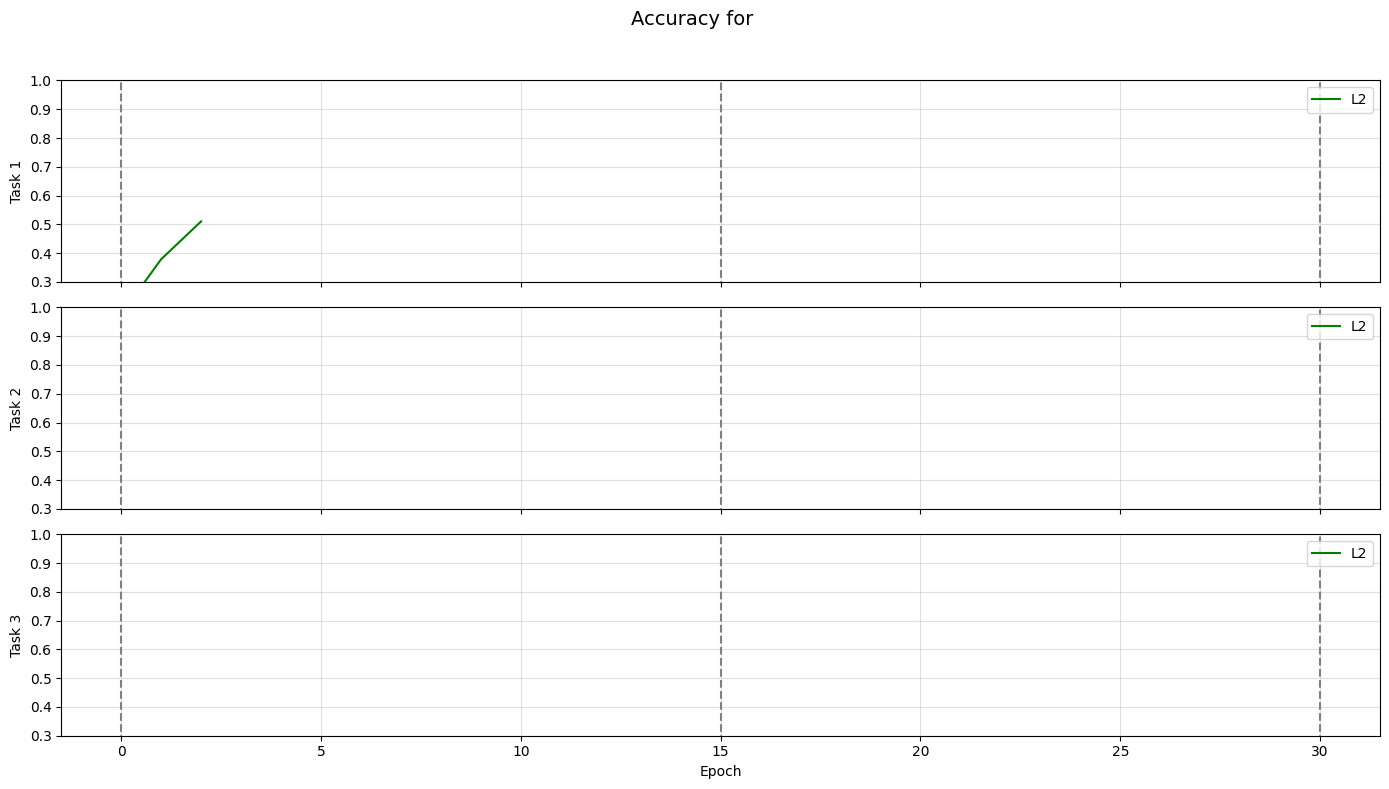

In [286]:
n_tasks, total_epochs = bla.shape
fig, axes = plt.subplots(n_tasks, 1, figsize=(14, 8), sharex=True)

for i in range(n_tasks):
#valid_epochs_sgd = np.where(metrics["sgd"]["train_accuracies"][i] >= 0)[0]
#axes[i].plot(valid_epochs_sgd, metrics["sgd"]["train_accuracies"][i, valid_epochs_sgd], label=f"SGD", color = "blue")

#valid_epochs_ewc = np.where(metrics["ewc"]["train_accuracies"][i] >= 0)[0]
#axes[i].plot(valid_epochs_ewc, metrics["ewc"]["train_accuracies"][i, valid_epochs_ewc], label=f"EWC", color = "red")

    valid_epochs_l2 = np.where(bla >= 0)[0]
    axes[i].plot(valid_epochs_l2, bla[i, valid_epochs_l2], label=f"L2", color = "green")    

    axes[i].vlines(np.arange(0, total_epochs, num_epochs), 0.2, 1.0, linestyles="--", colors="gray")
    axes[i].set_ylabel(f"Task {i + 1}")
    axes[i].legend(loc="upper right", fontsize=10)
    axes[i].set_ylim(0.3, 1.0)
    axes[i].grid(alpha=0.4)

plt.xlabel("Epoch")
fig.suptitle(f"Accuracy for ", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96]) 


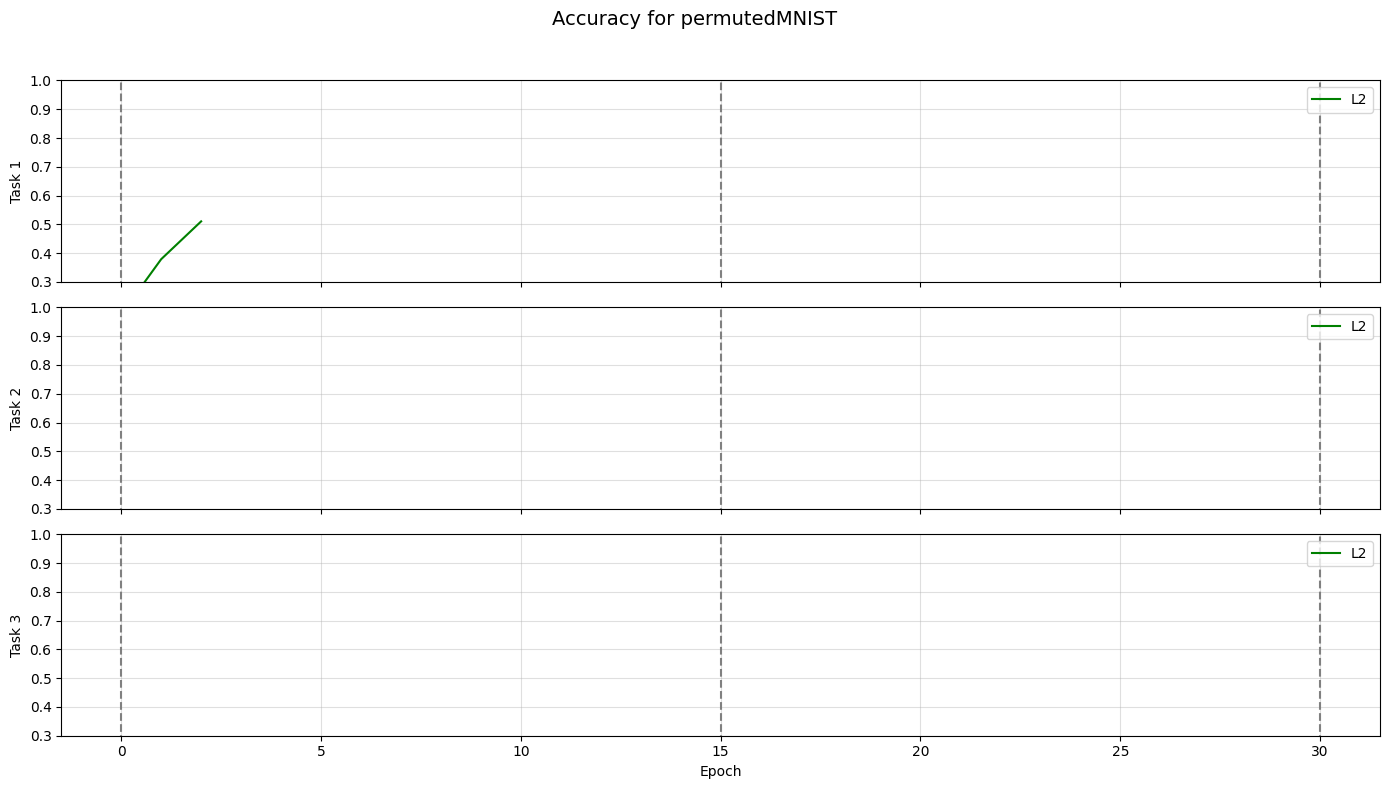

In [282]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
plot_fig_2A(metrics_perm, num_epochs, "permutedMNIST")
#plot_fig_2A(metrics_rot, num_epochs, "rotatedMNIST")